## DeepAR (based off of AWS synthetic data example) version 0.2

This version if going to follow from this <a href = "https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb">AWS DeepAR synthetic</a> data example.

In [78]:
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import sagemaker
import boto3

In [79]:
bucket = '#####'
prefix = 'sagemaker/synthetic-example'

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

freq = '5min'

In [80]:
data_key = 'Bainbridge_Departures_Master.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location, parse_dates = ["timestamps"], index_col = "timestamps")
del df.index.name

<a href = "https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-certain-columns-is-nan">How to drop rows of Pandas DataFrame whose value in certain columns is NaN</a>

<a href = "https://stackoverflow.com/a/49291779">Delete rows if there are null values in a specific column in Pandas dataframe [duplicate]</a>

In [81]:
df = df.asfreq(freq)

In [83]:
len(df["2013-02-03"])

288

Looks like there are exactly 288 entires per day.

`prediction_length` is the number of predictions we want to train our model to make

We also need to configure the so-called `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`. In our example we will use a longer `context_length` of `72`. Note that in addition to the `context_length` the model also takes into account the values of the time series at typical seasonal windows e.g. for hourly data the model will look at the value of the series 24h ago, one week ago one month ago etc. So it is not necessary to make the `context_length` span an entire month if you expect monthly seasonalities in your hourly data.

In [84]:
prediction_length = 288
context_length = 250

In [85]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [86]:
df_first_year = 2013
df_last_year = 2017

`time_series` is a list of `pandas.Series` objects, each series is a month worth of `seconds_late` data

In [87]:
time_series = []

for year in range (df_first_year, df_last_year + 1):
    for month in range(1,13):
        index = "{}-{}".format(year, month)
        time_series.append((df[index]["seconds_late"]))

In [88]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

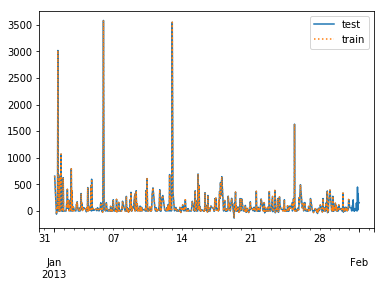

In [90]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [91]:
import json
import s3fs

In [92]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [93]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

### Train a model

In [94]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='deepar-bainbridge-departures-ae',
    output_path="s3://" + s3_output_path
)

In [95]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [96]:
estimator.set_hyperparameters(**hyperparameters)

In [97]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: deepar-bainbridge-departures-ae-2019-04-15-20-46-00-369


2019-04-15 20:46:00 Starting - Starting the training job...
2019-04-15 20:46:02 Starting - Launching requested ML instances.........
2019-04-15 20:47:39 Starting - Preparing the instances for training...
2019-04-15 20:48:26 Downloading - Downloading input data
2019-04-15 20:48:26 Training - Downloading the training image...
2019-04-15 20:49:01 Training - Training image download completed. Training in progress..
Arguments: train
[04/15/2019 20:49:04 INFO 140344170936128] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'l

[04/15/2019 20:49:47 INFO 140344170936128] Epoch[2] Batch[0] avg_epoch_loss=7.012396
[04/15/2019 20:49:51 INFO 140344170936128] Epoch[2] Batch[5] avg_epoch_loss=6.688659
[04/15/2019 20:49:51 INFO 140344170936128] Epoch[2] Batch [5]#011Speed: 47.18 samples/sec#011loss=6.688659
[04/15/2019 20:49:54 INFO 140344170936128] processed a total of 311 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7279.009819030762, "sum": 7279.009819030762, "min": 7279.009819030762}}, "EndTime": 1555361394.043412, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1555361386.764336}

[04/15/2019 20:49:54 INFO 140344170936128] #throughput_metric: host=algo-1, train throughput=42.7247392477 records/second
[04/15/2019 20:49:54 INFO 140344170936128] #progress_metric: host=algo-1, completed 15 % of epochs
[04/15/2019 20:49:54 INFO 140344170936128] best epoch loss so far
[04/15/2019 20:49:54 INFO 140344170936128] Saved checkpoint to "/opt/ml/model/st

[04/15/2019 20:50:40 INFO 140344170936128] Epoch[9] Batch[5] avg_epoch_loss=5.715822
[04/15/2019 20:50:40 INFO 140344170936128] Epoch[9] Batch [5]#011Speed: 47.76 samples/sec#011loss=5.715822
[04/15/2019 20:50:43 INFO 140344170936128] processed a total of 296 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7125.616073608398, "sum": 7125.616073608398, "min": 7125.616073608398}}, "EndTime": 1555361443.528072, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1555361436.402383}

[04/15/2019 20:50:43 INFO 140344170936128] #throughput_metric: host=algo-1, train throughput=41.5395867636 records/second
[04/15/2019 20:50:43 INFO 140344170936128] #progress_metric: host=algo-1, completed 50 % of epochs
[04/15/2019 20:50:43 INFO 140344170936128] best epoch loss so far
[04/15/2019 20:50:43 INFO 140344170936128] Saved checkpoint to "/opt/ml/model/state_b1fd8e04-d771-442f-b093-467c90427e23-0000.params"
#metrics {"Metrics": {"state.se

[04/15/2019 20:51:32 INFO 140344170936128] Epoch[16] Batch[5] avg_epoch_loss=5.008493
[04/15/2019 20:51:32 INFO 140344170936128] Epoch[16] Batch [5]#011Speed: 47.39 samples/sec#011loss=5.008493
[04/15/2019 20:51:35 INFO 140344170936128] processed a total of 317 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7149.451971054077, "sum": 7149.451971054077, "min": 7149.451971054077}}, "EndTime": 1555361495.595776, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1555361488.44626}

[04/15/2019 20:51:35 INFO 140344170936128] #throughput_metric: host=algo-1, train throughput=44.3382569816 records/second
[04/15/2019 20:51:35 INFO 140344170936128] #progress_metric: host=algo-1, completed 85 % of epochs
[04/15/2019 20:51:35 INFO 140344170936128] best epoch loss so far
[04/15/2019 20:51:35 INFO 140344170936128] Saved checkpoint to "/opt/ml/model/state_06127b87-def0-4b4a-8a37-c927a8ded3e4-0000.params"
#metrics {"Metrics": {"state.s


2019-04-15 20:54:05 Uploading - Uploading generated training model
2019-04-15 20:54:16 Completed - Training job completed
Billable seconds: 362


### Create endpoint and predictor

In [98]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    #instance_type='ml.m4.xlarge',
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: deepar-bainbridge-departures-ae-2019-04-15-20-46-00-369
INFO:sagemaker:Creating endpoint-config with name deepar-bainbridge-departures-ae-2019-04-15-20-46-00-369
INFO:sagemaker:Creating endpoint with name deepar-bainbridge-departures-ae-2019-04-15-20-46-00-369


---------------------------------------------------------------------------------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [106]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [107]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    #endpoint = "bainbridge-ferry-predictor",
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

### Make predictions and plot results

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [108]:
list_of_df = predictor.predict(time_series_training[:12])
actual_data = time_series[:12]

In [109]:
def plot_results(list_of_df):
    for k in range(len(list_of_df)):
        plt.figure(figsize=(12,6))
        actual_data[k][-prediction_length-context_length:].plot(label='target')
        p10 = list_of_df[k]['0.1']
        p90 = list_of_df[k]['0.9']
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        list_of_df[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

These graphs depict how the model would have performed predicting each month of 2013. Some are better than other but overall does not seem too bad!

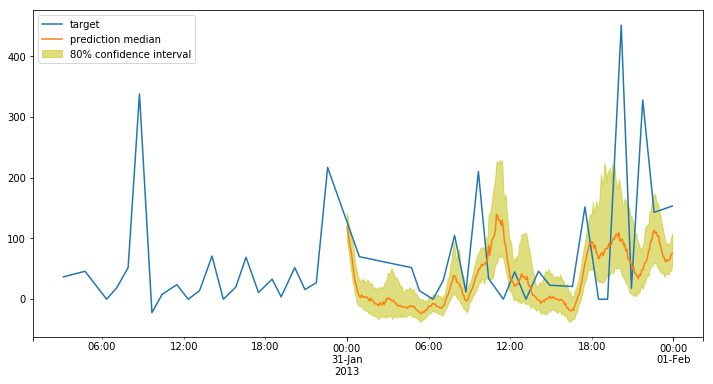

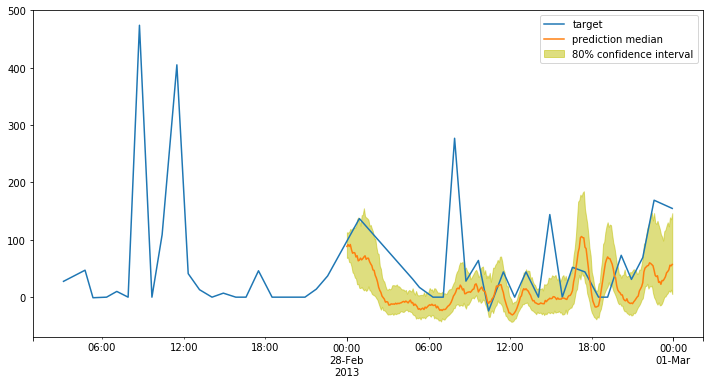

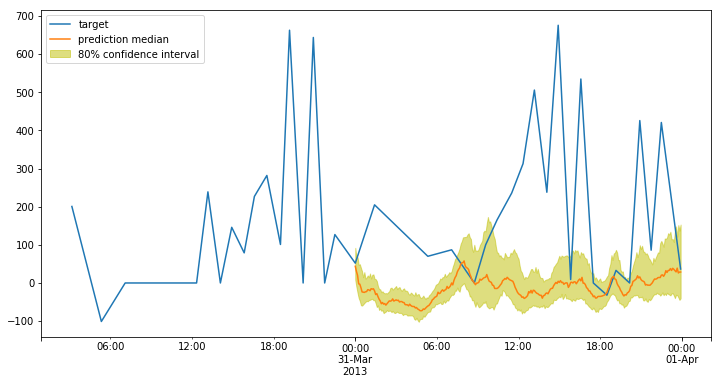

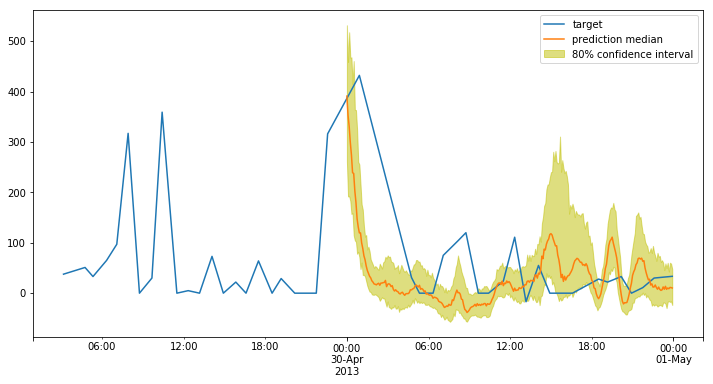

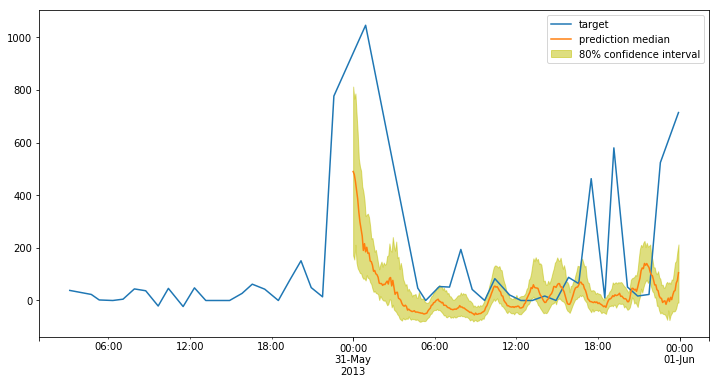

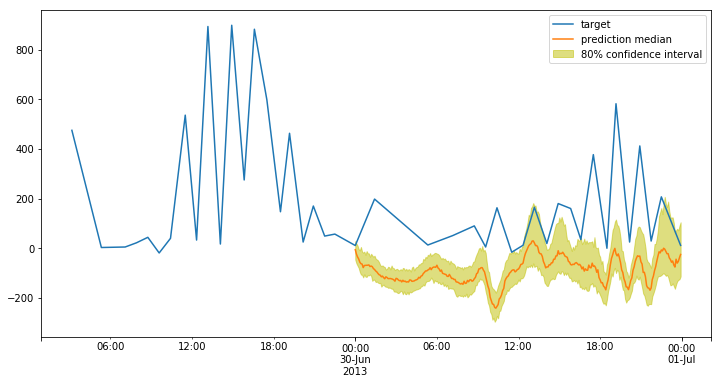

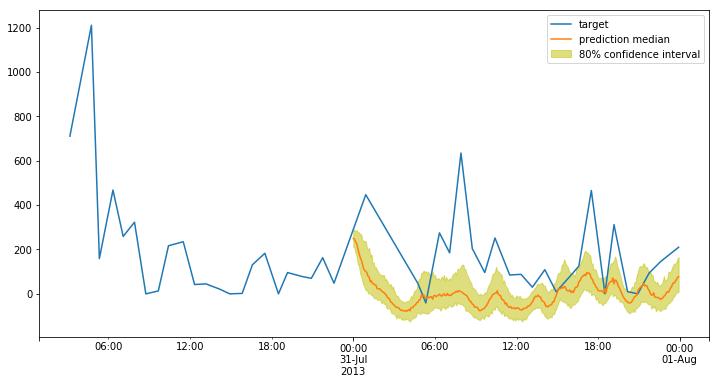

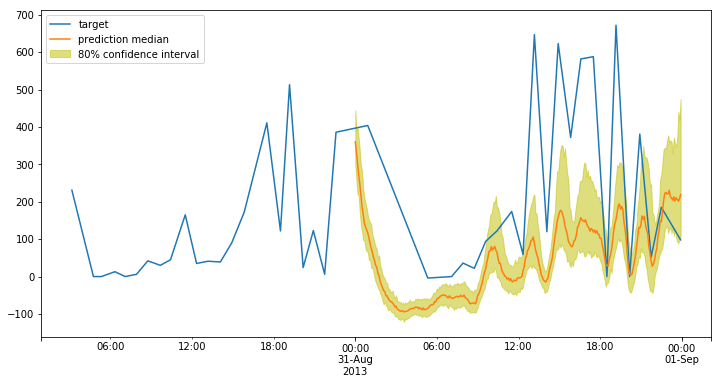

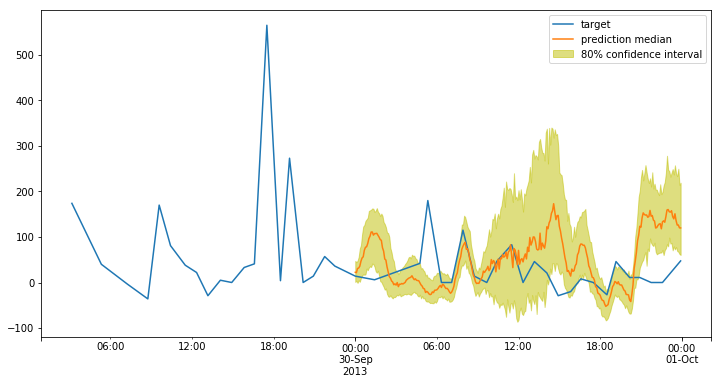

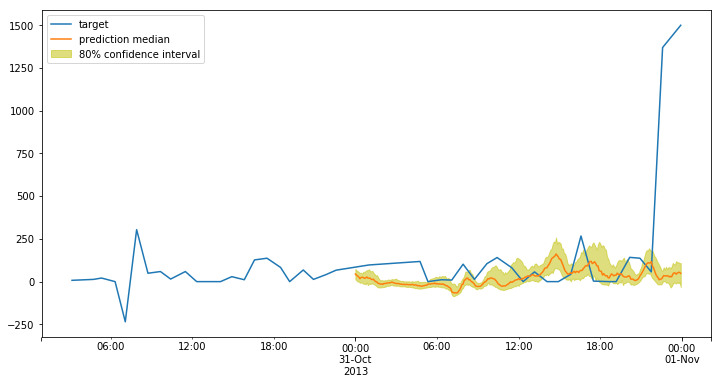

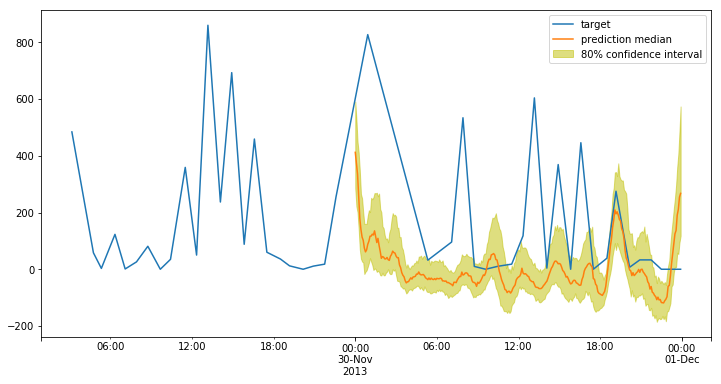

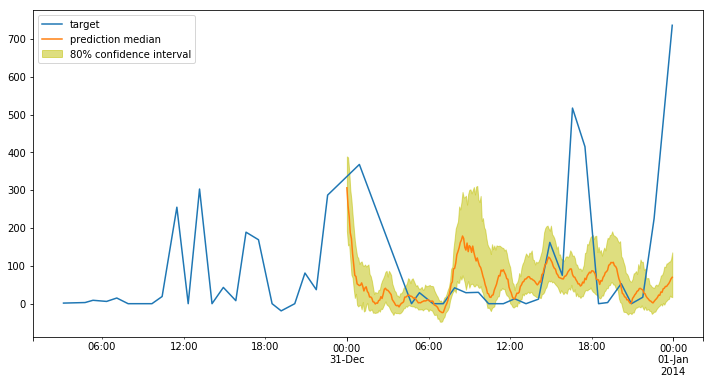

In [110]:
plot_results(list_of_df)

## Making predictions with daily series

In the first prediction above the predictor takes in a month worth of data. I want to see if I can also just pass in one day's worth of data to the same model.

In [111]:
time_series = []

for year in range (df_first_year, df_last_year + 1):
    for month in range(1,13):
        for day in range(1, calendar.monthrange(year, month)[1] + 1):
            index = "{}-{}-{}".format(year, month, day)
            time_series.append((df[index]["seconds_late"]))
            
time_series_training = []

for ts in time_series:
    time_series_training.append(ts[:-250])

In [112]:
list_of_df = predictor.predict(time_series_training[:7])
actual_data = time_series[:7]

This is how the model would be performing predicting some specific days in 2013.

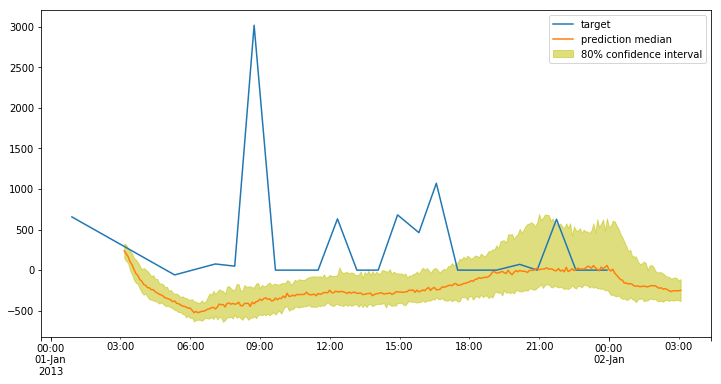

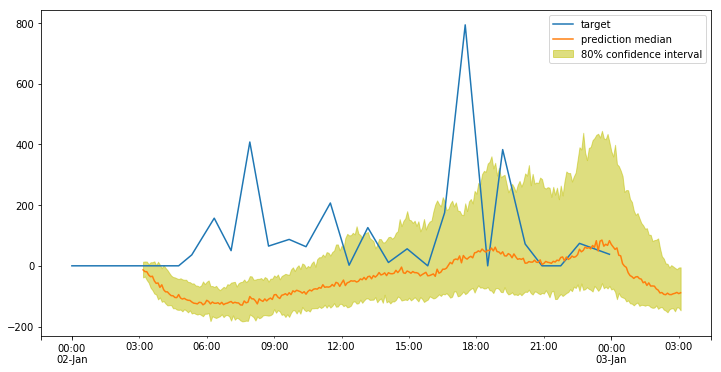

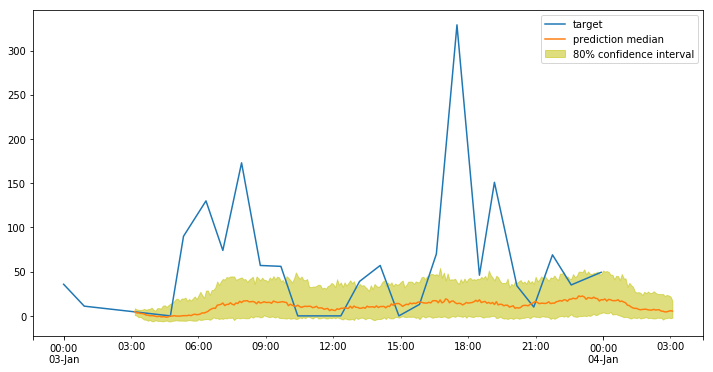

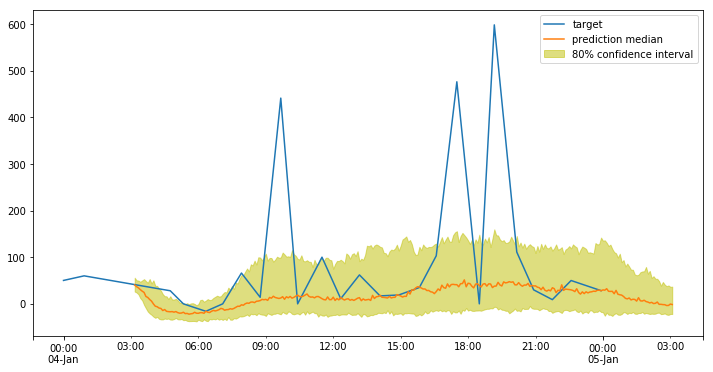

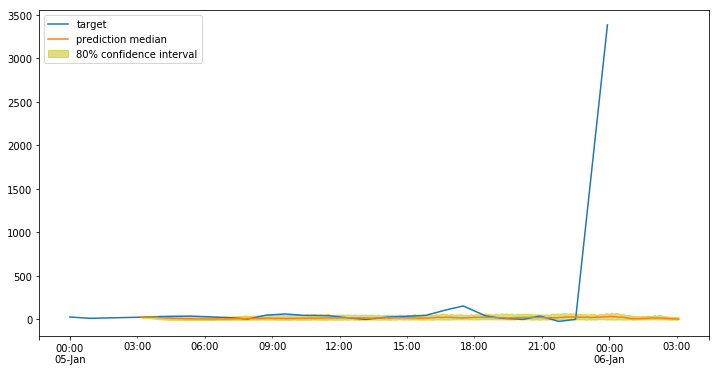

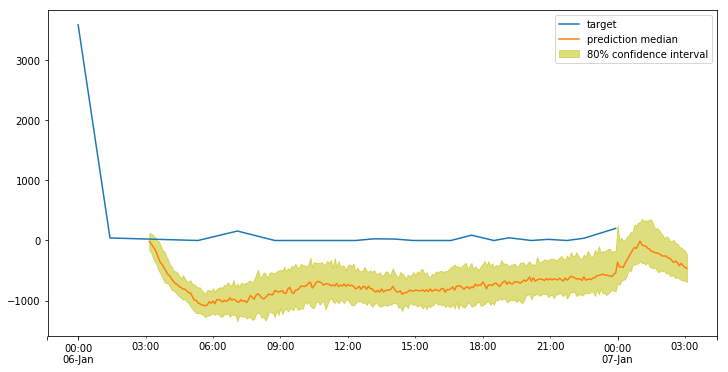

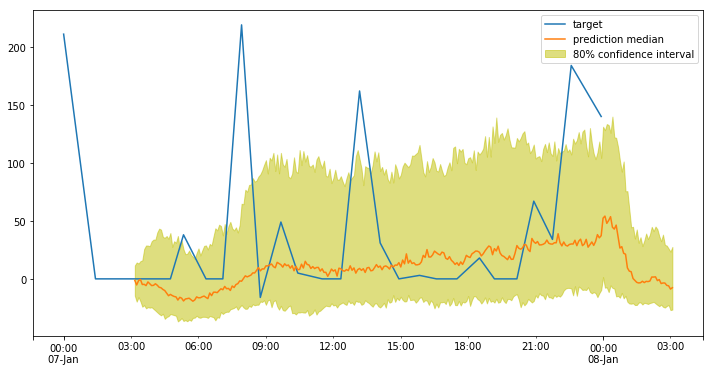

In [113]:
plot_results(list_of_df)